# Proactive Attrition Management Customer Churn Prediction Case Study

## Case Scenario

This case calls for devoleping a model to predict the customer Churn for "Cell2Cell" a telecom company that seeks to create an incentive plan that will aid in enticing customers who would be Churners and make them remain with Cell2Cell. 

**The Data** <br>
The provided data is a scaled down version of the full data of an anonymus telecom company. There are 71,047 customers and 75 potential predictor variables. The dataset is already divided into "Calibration" and "Validation" data. The calibration data has equal amount of churners and non-churners.

**The Analysis**<br>
For analysis here, we will use a Logistic Regression. Logistic regression fits in a logit curve to the data and provides a probability for the happening or non happening of an event (the event in this case refers to Churn). It predicts first, the log likelihood which can be calculated with linear regression as the log-likelihood takes the form of a straight line.  

## Case Solution

Loading the required libraries

In [66]:
library(data.table)
library(InformationValue)
library(car)
library(caret)
library(dplyr)
library(ModelMetrics)
library(Hmisc)
library(psych)
library(repr)
library(ggthemes)
options(scipen = 999)

Warning message:
"package 'ggthemes' was built under R version 3.5.3"

In [2]:
cust <- read.csv("Proactive Attrition Management-Logistic Regression Case Study.csv",header = T)

We first look at the fields of the data _(The Data dictionary is available in the pdf file in the folder)_

In [3]:
str(cust)

'data.frame':	71047 obs. of  78 variables:
 $ REVENUE : num  57.5 82.3 31.7 62.1 25.2 ...
 $ MOU     : num  482.8 1312.2 25.5 97.5 2.5 ...
 $ RECCHRGE: num  37.4 75 30 66 25 ...
 $ DIRECTAS: num  0.25 1.24 0.25 2.48 0 2.23 0.25 0 0.74 0 ...
 $ OVERAGE : num  22.8 0 0 0 0 ...
 $ ROAM    : num  0 0 0 0 0 35.5 0 0 1.29 0 ...
 $ CHANGEM : num  532.2 156.8 59.5 23.5 -2.5 ...
 $ CHANGER : num  50.99 8.14 4.03 6.82 -0.23 ...
 $ DROPVCE : num  8.33 52 0 0 0 9 3.33 2 2.67 1.67 ...
 $ BLCKVCE : num  1 7.67 1 0.33 0 0 1.67 0.67 6 0.33 ...
 $ UNANSVCE: num  61.33 76 2.33 4 0.33 ...
 $ CUSTCARE: num  1.67 4.33 0 4 0 0.33 1 0 4.33 0.33 ...
 $ THREEWAY: num  0.33 1.33 0 0 0 0 0 0 0 0 ...
 $ MOUREC  : num  55.28 200.32 0 0 1.13 ...
 $ OUTCALLS: num  46.33 370.33 0 3.67 0.33 ...
 $ INCALLS : num  6.33 147 0 0 0 4.67 3.67 4.67 8.33 5.67 ...
 $ PEAKVCE : num  83.67 555.67 1.67 7.67 0.67 ...
 $ OPEAKVCE: num  157 303.67 1.67 7.33 0.67 ...
 $ DROPBLK : num  9.33 59.67 1 0.33 0 ...
 $ CALLFWDV: num  0 0 0 0

We first remove two variables, one is a variables that does not provide any useful information and another used to divide the data into calibration and validation data so that further processing can be done with ease

In [4]:
dta <- cust
CALIBRAT <- dta$CALIBRAT
dta$CALIBRAT <- NULL
dta$CHURNDEP <- NULL

Variables with too many levels and can overfit the model will be removed along with those that indicate the missing and non missing values in the variable.

In [5]:
dta$CSA <- NULL
dta$CUSTOMER <- NULL
dta$INCMISS <- NULL
dta$SETPRCM <- NULL

Variables that measure items are done after churn has occured is removed 

In [6]:
dta$RETCALL <- NULL
dta$RETCALLS <- NULL
dta$RETACCPT <- NULL
dta$NEWCELLN <- NULL # this is a variable that already has a correlated column existing in the data

Now we use user defined funtions to get to know the data better

In [7]:
about <- function(x){
  if(class(x)=="numeric"){
  n = length(x)
  nmiss = sum(is.na(x))
  nmiss_pct = (mean(is.na(x)))*100
  sum = sum(x, na.rm=T)
  mean = mean(x, na.rm=T)
  median = quantile(x, p=0.5, na.rm=T)
  std = sd(x, na.rm=T)
  var = var(x, na.rm=T)
  range = max(x, na.rm=T)-min(x, na.rm=T)
  pctl = quantile(x, p=c(0, 0.01, 0.05,0.1,0.25,0.5, 0.75,0.9,0.95,0.99,1), na.rm=T)

  return(c(N=n, Nmiss =nmiss, Nmiss_pct = nmiss_pct, sum=sum, avg=mean, meidan=median, std=std, var=var, range=range, pctl=pctl))
}
else{
  Var_Type=class(x)
  n<-length(x)
  nmiss<-sum(is.na(x))
  nmiss_pct = (mean(is.na(x)))*100
  return( c(Var_Type=Var_Type, n=n,nmiss=nmiss,Nmiss_pct = nmiss_pct))
}
}

Now we examine those variables

In [8]:
nums <- sapply(dta,is.numeric)
abt_nums <- data.frame(t(apply(dta[nums], 2, about)))
abt_nums

,N,Nmiss,Nmiss_pct,sum,avg,meidan.50.,std,var,range,pctl.0.,pctl.1.,pctl.5.,pctl.10.,pctl.25.,pctl.50.,pctl.75.,pctl.90.,pctl.95.,pctl.99.,pctl.100.
REVENUE,71047,216,0.304024097,4168684.94,58.85396140,48.53,44.2436131,1957.4973041,1229.55,-6.17,10.000,15.515,26.160,33.64,48.53,71.030,103.950,135.390,225.5120,1223.38
MOU,71047,216,0.304024097,37237867.76,525.72839237,366.00,530.1342593,281042.3328604,7667.75,0.00,0.000,20.415,52.750,158.25,366.00,721.750,1202.000,1580.250,2450.1250,7667.75
RECCHRGE,71047,216,0.304024097,3320308.78,46.87649165,44.99,23.9151030,571.9321521,411.28,-11.29,9.190,10.000,19.990,30.00,44.99,59.990,75.000,85.000,119.9900,399.99
DIRECTAS,71047,216,0.304024097,63379.66,0.89480115,0.25,2.1978148,4.8303898,159.39,0.00,0.000,0.000,0.000,0.00,0.25,0.990,2.480,4.210,9.6500,159.39
OVERAGE,71047,216,0.304024097,2839994.43,40.09535980,2.50,96.3471032,9282.7643027,4320.75,0.00,0.000,0.000,0.000,0.00,2.50,40.750,115.750,190.375,427.6750,4320.75
ROAM,71047,216,0.304024097,86521.92,1.22152617,0.00,9.0811962,82.4681238,1112.45,0.00,0.000,0.000,0.000,0.00,0.00,0.260,2.130,5.090,21.5570,1112.45
CHANGEM,71047,502,0.706574521,-765163.62,-10.84646141,-5.00,255.3143155,65185.3996861,9067.25,-3875.00,-831.890,-376.250,-229.250,-83.00,-5.00,65.750,208.500,345.250,739.6700,5192.25
CHANGER,71047,502,0.706574521,-85072.02,-1.20592558,-0.29,38.7706954,1503.1668189,3591.22,-1107.74,-104.536,-47.500,-27.776,-7.11,-0.29,1.600,21.810,46.218,118.3456,2483.48
DROPVCE,71047,0,0.000000000,426987.32,6.00992751,3.00,9.0061745,81.1111793,221.67,0.00,0.000,0.000,0.000,0.67,3.00,7.670,15.000,22.000,42.0000,221.67
BLCKVCE,71047,0,0.000000000,288997.57,4.06769561,1.00,10.6708225,113.8664532,384.33,0.00,0.000,0.000,0.000,0.00,1.00,3.670,10.000,17.330,47.0000,384.33


We impute the missing values with the value of mean

In [9]:
dta[nums] <-data.frame(apply(dta[nums],2, function(x) impute(x, mean)))
dta[dta$INCOME==0,"INCOME"] <- 4.33
dta[dta$SETPRC==0,"SETPRC"] <- 35.79
dta$EQPDAYS <- round(dta$EQPDAYS,digits = 0) # This is rounded as all the values in this variable are integers

We now split the data according to their types

In [10]:
nums <- subset(dta, select = c( REVENUE, MOU, RECCHRGE, DIRECTAS, OVERAGE, ROAM, CHANGEM, CHANGER, DROPVCE, 
                                BLCKVCE, UNANSVCE, CUSTCARE, CALLFWDV, CALLWAIT, MONTHS, UNIQSUBS, ACTVSUBS, PHONES,  
                                MODELS, EQPDAYS, AGE1, AGE2, REFER, SETPRC, THREEWAY, MOUREC, OUTCALLS, INCALLS,  PEAKVCE, 
                                OPEAKVCE, DROPBLK,INCOME))

others <- subset(dta, select = c(CHURN, CHILDREN, CREDITA, CREDITAA, CREDITB, CREDITC, CREDITDE,
                                 CREDITGY, CREDITZ, PRIZMRUR, PRIZMUB, PRIZMTWN, REFURB,
                                 WEBCAP, TRUCK, RV, OCCPROF, OCCCLER, OCCCRFT, OCCSTUD, OCCHMKR,
                                 OCCRET, OCCSELF, OWNRENT, MARRYUN, MARRYYES, MARRYNO, MAILORD, 
                                 MAILRES, MAILFLAG, TRAVEL, PCOWN, CREDITCD, NEWCELLY,
                                 MCYCLE,CREDITAD))

We also round up all the others variables too to ensure that they retain their chatechteristics, if their value had been imputed

In [11]:
others <- apply(others,2,FUN = function(x) round(x,digits = 0))

We also examine the "other" variables

In [12]:
abt_others <- data.frame(t(apply(others, 2, about)))
abt_others

,N,Nmiss,Nmiss_pct,sum,avg,meidan.50.,std,var,range,pctl.0.,pctl.1.,pctl.5.,pctl.10.,pctl.25.,pctl.50.,pctl.75.,pctl.90.,pctl.95.,pctl.99.,pctl.100.
CHURN,71047,0,0,20609,0.290075584,0,0.45380022,0.205934638,1,0,0,0,0,0,0,1,1,1,1,1
CHILDREN,71047,0,0,17221,0.242388841,0,0.42853130,0.183639076,1,0,0,0,0,0,0,0,1,1,1,1
CREDITA,71047,0,0,11912,0.167663659,0,0.37356997,0.139554521,1,0,0,0,0,0,0,0,1,1,1,1
CREDITAA,71047,0,0,26350,0.370881248,0,0.48304413,0.233331632,1,0,0,0,0,0,0,1,1,1,1,1
CREDITB,71047,0,0,11689,0.164524892,0,0.37075381,0.137458387,1,0,0,0,0,0,0,0,1,1,1,1
CREDITC,71047,0,0,7420,0.104437907,0,0.30582993,0.093531947,1,0,0,0,0,0,0,0,1,1,1,1
CREDITDE,71047,0,0,9128,0.128478331,0,0.33462401,0.111973226,1,0,0,0,0,0,0,0,1,1,1,1
CREDITGY,71047,0,0,1609,0.022646980,0,0.14877636,0.022134406,1,0,0,0,0,0,0,0,0,0,1,1
CREDITZ,71047,0,0,2939,0.041366982,0,0.19913893,0.039656313,1,0,0,0,0,0,0,0,0,0,1,1
PRIZMRUR,71047,0,0,3392,0.047743043,0,0.21322356,0.045464285,1,0,0,0,0,0,0,0,0,0,1,1


Now we do outlier treatment for all the numeric values. REFER and CALLFWDV are not treated because of the way in which their values are spread. We use a UDf for the variables which did not have missing values and for the rest, we will manually cap the outliers.

In [13]:
outlier_treat <- function(x){
  UC1 = quantile(x, p=0.95,na.rm=T)
  LC1 = quantile(x, p=0.05,na.rm=T)
  
  x=ifelse(x>UC1, UC1, x)
  x=ifelse(x<LC1, LC1, x)
  return(x)
}

treat <- c("DROPVCE", "BLCKVCE", "UNANSVCE", "CUSTCARE", "CALLWAIT", "MONTHS", "UNIQSUBS", "ACTVSUBS", "PHONES",  
           "MODELS", "EQPDAYS", "SETPRC", "THREEWAY", "MOUREC", "OUTCALLS", "INCALLS", "PEAKVCE", 
           "OPEAKVCE", "DROPBLK","INCOME")

nums[,treat] <-lapply(nums[,treat],FUN = outlier_treat)

In [14]:
nums$AGE1 =ifelse(nums$AGE1>62, 62, nums$AGE1)
nums$AGE1 =ifelse(nums$AGE1<0, 0, nums$AGE1)
nums$AGE2 =ifelse(nums$AGE2>62, 62, nums$AGE2)
nums$AGE2 =ifelse(nums$AGE2<0, 0, nums$AGE2)
nums$CHANGEM =ifelse(nums$CHANGEM>345.25, 345.25, nums$CHANGEM)
nums$CHANGEM =ifelse(nums$CHANGEM< (-376.250), -376.250, nums$CHANGEM)
nums$CHANGER =ifelse(nums$CHANGER>46.218, 46.218, nums$CHANGER)
nums$CHANGER =ifelse(nums$CHANGER< (-47.500), -47.500, nums$CHANGER)
nums$REVENUE =ifelse(nums$REVENUE<15.515, 15.515, nums$REVENUE)
nums$REVENUE =ifelse(nums$REVENUE>135.39, 135.39, nums$REVENUE)
nums$MOU =ifelse(nums$MOU<20.415, 20.415, nums$MOU)
nums$MOU =ifelse(nums$MOU>1580.25, 1580.25, nums$MOU)
nums$RECCHRGE =ifelse(nums$RECCHRGE>85, 85, nums$RECCHRGE)
nums$RECCHRGE =ifelse(nums$RECCHRGE<10, 10, nums$RECCHRGE)
nums$DIRECTAS =ifelse(nums$DIRECTAS>4.21, 4.21, nums$DIRECTAS)
nums$DIRECTAS =ifelse(nums$DIRECTAS<0, 0, nums$DIRECTAS)
nums$OVERAGE =ifelse(nums$OVERAGE>190.375, 190.375, nums$OVERAGE)
nums$OVERAGE =ifelse(nums$OVERAGE<0, 0, nums$OVERAGE)
nums$ROAM =ifelse(nums$ROAM>5.09, 5.09, nums$ROAM)
nums$ROAM =ifelse(nums$ROAM<0, 0, nums$ROAM)

We will now apply Chi Square Test to see the relationship between categorical variables and the target variable CHURN. This will be a way to select those variables that make are relevant.

In [15]:
chisq.test(xtabs(~CHURN+CHILDREN,data = others)) # remove
chisq.test(xtabs(~CHURN+CREDITA,data = others))
chisq.test(xtabs(~CHURN+CREDITAA,data = others))
chisq.test(xtabs(~CHURN+CREDITB,data = others)) 
chisq.test(xtabs(~CHURN+CREDITC,data = others)) 
chisq.test(xtabs(~CHURN+CREDITDE,data = others))
chisq.test(xtabs(~CHURN+CREDITGY,data = others)) #remove
chisq.test(xtabs(~CHURN+CREDITZ,data = others)) # remove
chisq.test(xtabs(~CHURN+PRIZMRUR,data = others))
chisq.test(xtabs(~CHURN+PRIZMTWN,data = others))
chisq.test(xtabs(~CHURN+PRIZMUB,data = others))
chisq.test(xtabs(~CHURN+WEBCAP,data = others)) 
chisq.test(xtabs(~CHURN+TRUCK,data = others)) #remove
chisq.test(xtabs(~CHURN+RV,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCPROF,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCCLER,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCCRFT,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCSTUD,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCHMKR,data = others)) #remove
chisq.test(xtabs(~CHURN+OCCRET,data = others))
chisq.test(xtabs(~CHURN+OWNRENT,data = others))
chisq.test(xtabs(~CHURN+MARRYUN,data = others))
chisq.test(xtabs(~CHURN+MARRYYES,data = others)) #remove
chisq.test(xtabs(~CHURN+MARRYNO,data = others))
chisq.test(xtabs(~CHURN+MAILRES,data = others)) 
chisq.test(xtabs(~CHURN+MAILFLAG,data = others)) #remove
chisq.test(xtabs(~CHURN+TRAVEL,data = others)) #remove
chisq.test(xtabs(~CHURN+PCOWN,data = others)) #remove
chisq.test(xtabs(~CHURN+CREDITCD,data = others)) 
chisq.test(xtabs(~CHURN+NEWCELLY,data = others))
chisq.test(xtabs(~CHURN+MCYCLE,data = others)) #remove
chisq.test(xtabs(~CHURN+CREDITAD,data = others)) #remove
chisq.test(xtabs(~CHURN+REFURB,data = others)) 
chisq.test(xtabs(~CHURN+OCCSELF,data = others)) #remove
chisq.test(xtabs(~CHURN+MAILORD,data = others))


	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CHILDREN, data = others)
X-squared = 1.882, df = 1, p-value = 0.1701



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITA, data = others)
X-squared = 31.132, df = 1, p-value = 0.00000002411



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITAA, data = others)
X-squared = 31.324, df = 1, p-value = 0.00000002183



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITB, data = others)
X-squared = 25.805, df = 1, p-value = 0.0000003778



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITC, data = others)
X-squared = 25.516, df = 1, p-value = 0.0000004387



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITDE, data = others)
X-squared = 222.92, df = 1, p-value < 0.00000000000000022



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITGY, data = others)
X-squared = 0.46199, df = 1, p-value = 0.4967



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITZ, data = others)
X-squared = 0.015846, df = 1, p-value = 0.8998



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + PRIZMRUR, data = others)
X-squared = 12.881, df = 1, p-value = 0.0003319



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + PRIZMTWN, data = others)
X-squared = 7.3586, df = 1, p-value = 0.006674



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + PRIZMUB, data = others)
X-squared = 6.8939, df = 1, p-value = 0.008649



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + WEBCAP, data = others)
X-squared = 271.64, df = 1, p-value < 0.00000000000000022



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + TRUCK, data = others)
X-squared = 0.046775, df = 1, p-value = 0.8288



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + RV, data = others)
X-squared = 0.11194, df = 1, p-value = 0.7379



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCPROF, data = others)
X-squared = 3.1512, df = 1, p-value = 0.07587



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCCLER, data = others)
X-squared = 0.5127, df = 1, p-value = 0.474



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCCRFT, data = others)
X-squared = 1.9165, df = 1, p-value = 0.1662



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCSTUD, data = others)
X-squared = 0.10758, df = 1, p-value = 0.7429



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCHMKR, data = others)
X-squared = 0.92535, df = 1, p-value = 0.3361



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCRET, data = others)
X-squared = 3.9005, df = 1, p-value = 0.04827



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OWNRENT, data = others)
X-squared = 16.868, df = 1, p-value = 0.00004007



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MARRYUN, data = others)
X-squared = 28.075, df = 1, p-value = 0.0000001167



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MARRYYES, data = others)
X-squared = 1.5099, df = 1, p-value = 0.2191



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MARRYNO, data = others)
X-squared = 20.966, df = 1, p-value = 0.000004675



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MAILRES, data = others)
X-squared = 42.508, df = 1, p-value = 0.00000000007039



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MAILFLAG, data = others)
X-squared = 0.029179, df = 1, p-value = 0.8644



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + TRAVEL, data = others)
X-squared = 1.0733, df = 1, p-value = 0.3002



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + PCOWN, data = others)
X-squared = 0.64202, df = 1, p-value = 0.423



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + CREDITCD, data = others)
X-squared = 7.6926, df = 1, p-value = 0.005545



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + NEWCELLY, data = others)
X-squared = 4.9185, df = 1, p-value = 0.02657



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MCYCLE, data = others)
X-squared = 2.0983, df = 1, p-value = 0.1475


Warning message in chisq.test(xtabs(~CHURN + CREDITAD, data = others)):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  xtabs(~CHURN + CREDITAD, data = others)
X-squared = 18.537, df = 15, p-value = 0.2355



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + REFURB, data = others)
X-squared = 63.187, df = 1, p-value = 0.00000000000000188



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + OCCSELF, data = others)
X-squared = 1.1312, df = 1, p-value = 0.2875



	Pearson's Chi-squared test with Yates' continuity correction

data:  xtabs(~CHURN + MAILORD, data = others)
X-squared = 39.942, df = 1, p-value = 0.0000000002616


The final selected variables are:

In [16]:
others2 <- others[,c("CHURN","CREDITAA","CREDITB","CREDITC","CREDITDE","PRIZMTWN", "PRIZMUB","WEBCAP","OWNRENT",
                     "MARRYUN","MAILRES","CREDITCD","NEWCELLY","OCCRET","CREDITA","PRIZMRUR","REFURB","MARRYNO",
                     "MAILORD")]

Now we merge all the variables

In [35]:
cust_ <- cbind(nums,others2)

We will run our first model with these variables and then use stepwise regression to select the final list of variables

In [18]:
fit1 <-glm(CHURN~.,data = cust_,family = binomial(logit),maxit=100)
summary(fit1)


Call:
glm(formula = CHURN ~ ., family = binomial(logit), data = cust_, 
    maxit = 100)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6324  -0.8578  -0.7266   1.3447   2.3542  

Coefficients:
               Estimate  Std. Error z value             Pr(>|z|)    
(Intercept) -1.08336460  0.08211746 -13.193 < 0.0000000000000002 ***
REVENUE      0.00271318  0.00080015   3.391             0.000697 ***
MOU         -0.00036228  0.00004773  -7.590    0.000000000000032 ***
RECCHRGE    -0.00385664  0.00084134  -4.584    0.000004563068851 ***
DIRECTAS    -0.00546586  0.00872723  -0.626             0.531118    
OVERAGE      0.00248896  0.00033639   7.399    0.000000000000137 ***
ROAM         0.02679983  0.00674524   3.973    0.000070930043076 ***
CHANGEM     -0.00089038  0.00006556 -13.581 < 0.0000000000000002 ***
CHANGER      0.00374785  0.00053120   7.055    0.000000000001721 ***
DROPVCE      0.01361880  0.00482823   2.821             0.004792 ** 
BLCKVCE      0.0042699

In [19]:
#step(fit1,direction = "both")

The final model given by stepwise regression is:

In [36]:
cust_ <- cbind(cust_,CALIBRAT)

In [37]:
summary(glm(formula = CHURN ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + 
        CHANGEM + CHANGER + DROPVCE + BLCKVCE + CUSTCARE + CALLWAIT + 
        MONTHS + UNIQSUBS + ACTVSUBS + PHONES + EQPDAYS + AGE1 + 
        REFER + SETPRC + THREEWAY + INCALLS + PEAKVCE + OPEAKVCE + 
        INCOME + CREDITAA + CREDITB + CREDITC + CREDITDE + PRIZMTWN + 
        PRIZMUB + WEBCAP + MAILRES + CREDITCD + NEWCELLY + PRIZMRUR + 
        REFURB + MARRYNO, family = binomial(logit), data = cust_, 
        maxit = 100))


Call:
glm(formula = CHURN ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + 
    CHANGEM + CHANGER + DROPVCE + BLCKVCE + CUSTCARE + CALLWAIT + 
    MONTHS + UNIQSUBS + ACTVSUBS + PHONES + EQPDAYS + AGE1 + 
    REFER + SETPRC + THREEWAY + INCALLS + PEAKVCE + OPEAKVCE + 
    INCOME + CREDITAA + CREDITB + CREDITC + CREDITDE + PRIZMTWN + 
    PRIZMUB + WEBCAP + MAILRES + CREDITCD + NEWCELLY + PRIZMRUR + 
    REFURB + MARRYNO, family = binomial(logit), data = cust_, 
    maxit = 100)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6228  -0.8583  -0.7269   1.3458   2.3074  

Coefficients:
               Estimate  Std. Error z value             Pr(>|z|)    
(Intercept) -1.04698462  0.06566370 -15.945 < 0.0000000000000002 ***
REVENUE      0.00263542  0.00079215   3.327             0.000878 ***
MOU         -0.00035352  0.00004420  -7.999  0.00000000000000126 ***
RECCHRGE    -0.00382317  0.00083956  -4.554  0.00000526899253690 ***
OVERAGE      0.00251443  0.00033543   7.496  

From this model, we will take the numerical variables and check the relevance of their transformations so that they are more relevant to the final model

In [ ]:
convert_select <- function(x){
  norm_ <- x
  log_ <- log(x)
  exp_ <- exp(x)
  sqrt_ <- sqrt(x)
  sqr_ <- (x)^2
  rec <- 1/x
  scaled <- scale(x,center = F)
  
  a <-summary(aov(norm_~cust_$CHURN))
  norm_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(log_~cust_$CHURN))
  log_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(exp_~cust_$CHURN))
  exp_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqrt_~cust_$CHURN))
  sqrt_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqr_~cust_$CHURN))
  sqr_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(rec~cust_$CHURN))
  rec1 <- a[[1]][[5]][[1]]
  a <-summary(aov(scaled~cust_$CHURN))
  scaled_1 <- a[[1]][[5]][[1]]
  
  reg1 <- glm(formula = cust_$CHURN ~ norm_, family = binomial(logit),maxit = 100)
  reg2 <- glm(formula = cust_$CHURN ~ log_, family = binomial(logit),maxit = 100)
  reg3 <- glm(formula = cust_$CHURN ~ exp_, family = binomial(logit),maxit = 100)
  reg4 <- glm(formula = cust_$CHURN ~ sqrt_, family = binomial(logit),maxit = 100)
  reg5 <- glm(formula = cust_$CHURN ~ sqr_, family = binomial(logit),maxit = 100)
  reg6 <- glm(formula = cust_$CHURN ~ rec, family = binomial(logit),maxit = 100)
  reg7 <- glm(formula = cust_$CHURN ~ scaled, family = binomial(logit),maxit = 100)
  
  r1 <- MLmetrics::Gini(y_pred = reg1$fitted.values, y_true = as.numeric(cust_$CHURN))
  r2 <- MLmetrics::Gini(y_pred = reg2$fitted.values, y_true = as.numeric(cust_$CHURN))
  r3 <- MLmetrics::Gini(y_pred = reg3$fitted.values, y_true = as.numeric(cust_$CHURN))
  r4 <- MLmetrics::Gini(y_pred = reg4$fitted.values, y_true = as.numeric(cust_$CHURN))
  r5 <- MLmetrics::Gini(y_pred = reg5$fitted.values, y_true = as.numeric(cust_$CHURN))
  r6 <- MLmetrics::Gini(y_pred = reg6$fitted.values, y_true = as.numeric(cust_$CHURN))
  r7 <- MLmetrics::Gini(y_pred = reg7$fitted.values, y_true = as.numeric(cust_$CHURN))
  
  maxi <- max(r1,r2,r3,r4,r5,r6,r7)
  
  
  return(c(normal=norm_1,log=log_1,exp=exp_1,sqrt=sqrt_1,sqr=sqr_1,rec=rec1,scaled = scaled_1,
           gini_norm = r1,gini_log = r2,gini_exp = r3,gini_sqrt = r4,gini_sqr = r5,gini_rec = r6,gini_scaled = r7,maximum = maxi))
}
convert_select(cust_$RECCHRGE) #scaled
convert_select(cust_$UNIQSUBS) #rec
convert_select(cust_$MONTHS) #rec
convert_select(cust_$REVENUE) #rec
convert_select(cust_$ACTVSUBS)
convert_select(cust_$PHONES) # sqrt, round
convert_select(cust_$SETPRC)
convert_select(cust_$INCOME) # exp
  
convert_select_log <- function(x){
  norm_ <- x
  exp_ <- exp(x)
  sqrt_ <- sqrt(x)
  sqr_ <- (x)^2
  scaled <- scale(x,center = T)
 
  a <-summary(aov(norm_~cust_$CHURN))
  norm_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqrt_~cust_$CHURN))
  sqrt_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqr_~cust_$CHURN))
  sqr_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(scaled~cust_$CHURN))
  scaled_1 <- a[[1]][[5]][[1]]
  
  reg1 <- glm(formula = cust_$CHURN ~ norm_, family = binomial(logit),maxit = 100)
  reg3 <- glm(formula = cust_$CHURN ~ exp_, family = binomial(logit),maxit = 100)
  reg4 <- glm(formula = cust_$CHURN ~ sqrt_, family = binomial(logit),maxit = 100)
  reg5 <- glm(formula = cust_$CHURN ~ sqr_, family = binomial(logit),maxit = 100)
  reg7 <- glm(formula = cust_$CHURN ~ scaled, family = binomial(logit),maxit = 100)
  
  r1 <- MLmetrics::Gini(y_pred = reg1$fitted.values, y_true = as.numeric(cust_$CHURN))
  r3 <- MLmetrics::Gini(y_pred = reg3$fitted.values, y_true = as.numeric(cust_$CHURN))
  r4 <- MLmetrics::Gini(y_pred = reg4$fitted.values, y_true = as.numeric(cust_$CHURN))
  r5 <- MLmetrics::Gini(y_pred = reg5$fitted.values, y_true = as.numeric(cust_$CHURN))
  r7 <- MLmetrics::Gini(y_pred = reg7$fitted.values, y_true = as.numeric(cust_$CHURN))

  maxi <- max(r1,r3,r4,r5,r7)
  
  return(c(normal=norm_1,sqrt=sqrt_1,sqr=sqr_1,scaled = scaled_1, gini_norm = r1,gini_exp = r3,gini_sqrt = r4,gini_sqr = r5,gini_scaled = r7,maximum = maxi))
}

convert_select_log(cust_$AGE1) #sqr
convert_select_log(cust_$OVERAGE) #sqrt
convert_select_log(cust_$DROPVCE) #sqrt
convert_select_log(cust_$OPEAKVCE) #sqrt
convert_select_log(cust_$PEAKVCE) #sqrt
convert_select_log(cust_$CHANGEM)
convert_select_log(cust_$CHANGER) #sqr
convert_select_log(cust_$ROAM) #sqr
convert_select_log(cust_$CUSTCARE) #sqrt
convert_select_log(cust_$THREEWAY)
convert_select_log(cust_$BLCKVCE) #sqrt
convert_select_log(cust_$CALLWAIT) #sqrt
convert_select_log(cust_$ACTVSUBS)
convert_select_log(cust_$INCALLS) #sqrt
convert_select_log(cust_$REFER)

convert_select_exp <- function(x){
  norm_ <- x
  #exp_ <- exp(x)
  sqrt_ <- sqrt(x)
  sqr_ <- (x)^2
  scaled <- scale(x,center = T)
  
  a <-summary(aov(norm_~cust_$CHURN))
  norm_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqrt_~cust_$CHURN))
  sqrt_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(sqr_~cust_$CHURN))
  sqr_1 <- a[[1]][[5]][[1]]
  a <-summary(aov(scaled~cust_$CHURN))
  scaled_1 <- a[[1]][[5]][[1]]
  
  reg1 <- glm(formula = cust_$CHURN ~ norm_, family = binomial(logit),maxit = 100)
  #reg3 <- glm(formula = cust_$CHURN ~ exp_, family = binomial(logit),maxit = 100)
  reg4 <- glm(formula = cust_$CHURN ~ sqrt_, family = binomial(logit),maxit = 100)
  reg5 <- glm(formula = cust_$CHURN ~ sqr_, family = binomial(logit),maxit = 100)
  reg7 <- glm(formula = cust_$CHURN ~ scaled, family = binomial(logit),maxit = 100)
  
  r1 <- MLmetrics::Gini(y_pred = reg1$fitted.values, y_true = as.numeric(cust_$CHURN))
  #r3 <- MLmetrics::Gini(y_pred = reg3$fitted.values, y_true = as.numeric(cust_$CHURN))
  r4 <- MLmetrics::Gini(y_pred = reg4$fitted.values, y_true = as.numeric(cust_$CHURN))
  r5 <- MLmetrics::Gini(y_pred = reg5$fitted.values, y_true = as.numeric(cust_$CHURN))
  r7 <- MLmetrics::Gini(y_pred = reg7$fitted.values, y_true = as.numeric(cust_$CHURN))
  
  maxi <- max(r1,r4,r5,r7)
  
  return(c(normal=norm_1,sqrt=sqrt_1,sqr=sqr_1,scaled = scaled_1, gini_norm = r1,gini_sqrt = r4,gini_sqr = r5,gini_scaled = r7,maximum = maxi))
}
convert_select_exp(cust_$MOU) #sqrt
convert_select_exp(cust_$EQPDAYS)


We apply the transformations to the variables

In [38]:
cust_1 <- cust_

cust_1$MONTHS <- 1/cust_$MONTHS
cust_1$DROPVCE <- sqrt(cust_$DROPVCE)
cust_1$OPEAKVCE <- sqrt(cust_$OPEAKVCE)
cust_1$OVERAGE <- sqrt(sqrt(cust_$OVERAGE))
cust_1$RECCHRGE <- scale(cust_$RECCHRGE)
cust_1$UNIQSUBS <- 1/(cust_$UNIQSUBS)
cust_1$AGE1 <- (cust_$AGE1)^2
cust_1$PEAKVCE <- sqrt(cust_$PEAKVCE)
cust_1$CHANGER <- (cust_$CHANGER)^2
cust_1$REVENUE <- 1/(cust_$REVENUE)
cust_1$PHONES <-  round(sqrt(cust_$PHONES),digits = 0)
cust_1$INCOME <- exp(cust_$INCOME)
cust_1$ROAM <- (cust_$ROAM)^2
cust_1$CUSTCARE <- sqrt(cust_$CUSTCARE)
cust_1$BLCKVCE <- sqrt(cust_$BLCKVCE)
cust_1$CALLWAIT <- sqrt(cust_$CALLWAIT)
cust_1$INCALLS <- sqrt(cust_$INCALLS)
cust_1$MOU <- sqrt(cust_$MOU)
cust_1$EQPDAYS <- round(sqrt(cust_$EQPDAYS))

Now we partition the data into Calibration and Validation

In [83]:
calib <- cust_1[cust_1$CALIBRAT == 1,]
valid <- cust_1[cust_1$CALIBRAT == 0,]

calib$CALIBRAT <- NULL
valid$CALIBRAT <- NULL

calib <- data.table(calib)
valid <- data.table(valid)

Using the model we obtainied from the first stepwise regression

In [40]:
form <- CHURN ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + 
        CHANGEM + CHANGER + DROPVCE + BLCKVCE + CALLWAIT + 
        MONTHS + UNIQSUBS + ACTVSUBS + EQPDAYS + AGE1 + SETPRC + 
        THREEWAY + INCALLS + PEAKVCE + INCOME + CREDITAA + CREDITB + 
        CREDITDE + PRIZMUB + WEBCAP + MAILRES + NEWCELLY + REFURB + 
        MARRYNO

fit2 <- glm(form,data = calib,family = binomial(logit),maxit = 100)
summary(fit2)


Call:
glm(formula = form, family = binomial(logit), data = calib, maxit = 100)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.91952  -1.13961   0.01666   1.13568   1.98909  

Coefficients:
                Estimate   Std. Error z value             Pr(>|z|)    
(Intercept)  0.619389578  0.135130432   4.584   0.0000045694545134 ***
REVENUE     -4.447156706  1.381378856  -3.219              0.00128 ** 
MOU         -0.016090923  0.002114412  -7.610   0.0000000000000274 ***
RECCHRGE    -0.052471464  0.018466750  -2.841              0.00449 ** 
OVERAGE      0.108148846  0.011668928   9.268 < 0.0000000000000002 ***
ROAM         0.007916131  0.001688927   4.687   0.0000027713367611 ***
CHANGEM     -0.000621836  0.000062221  -9.994 < 0.0000000000000002 ***
CHANGER      0.000083700  0.000017570   4.764   0.0000019000635500 ***
DROPVCE      0.107384249  0.012170123   8.824 < 0.0000000000000002 ***
BLCKVCE      0.042430882  0.010453298   4.059   0.0000492642558351 ***


We run a stepwise regression on this too

In [41]:
#step(fit2,direction = "both")

The final model now is

In [42]:
form <- CHURN ~ REVENUE + MOU + RECCHRGE + OVERAGE + ROAM + 
        CHANGEM + CHANGER + DROPVCE + BLCKVCE + CALLWAIT + 
        MONTHS + UNIQSUBS + ACTVSUBS + EQPDAYS + AGE1 + SETPRC + 
        THREEWAY + INCALLS + PEAKVCE + INCOME + CREDITAA + CREDITB + 
        CREDITDE + PRIZMUB + WEBCAP + MAILRES + NEWCELLY + REFURB + 
        MARRYNO
fit2 <- glm(form,data = calib,family = binomial(logit),maxit = 100)
summary(fit2)


Call:
glm(formula = form, family = binomial(logit), data = calib, maxit = 100)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.91952  -1.13961   0.01666   1.13568   1.98909  

Coefficients:
                Estimate   Std. Error z value             Pr(>|z|)    
(Intercept)  0.619389578  0.135130432   4.584   0.0000045694545134 ***
REVENUE     -4.447156706  1.381378856  -3.219              0.00128 ** 
MOU         -0.016090923  0.002114412  -7.610   0.0000000000000274 ***
RECCHRGE    -0.052471464  0.018466750  -2.841              0.00449 ** 
OVERAGE      0.108148846  0.011668928   9.268 < 0.0000000000000002 ***
ROAM         0.007916131  0.001688927   4.687   0.0000027713367611 ***
CHANGEM     -0.000621836  0.000062221  -9.994 < 0.0000000000000002 ***
CHANGER      0.000083700  0.000017570   4.764   0.0000019000635500 ***
DROPVCE      0.107384249  0.012170123   8.824 < 0.0000000000000002 ***
BLCKVCE      0.042430882  0.010453298   4.059   0.0000492642558351 ***


we check for multicollinearity in the data using VIF

In [43]:
vif(fit2)

REVENUE      MOU RECCHRGE  OVERAGE     ROAM  CHANGEM  CHANGER  DROPVCE 
3.560509 4.053290 3.237083 2.340188 1.056730 1.014548 1.536040 2.529446 
 BLCKVCE CALLWAIT   MONTHS UNIQSUBS ACTVSUBS  EQPDAYS     AGE1   SETPRC 
1.499729 2.389110 1.455251 3.155978 3.277318 1.862384 1.450293 1.393942 
THREEWAY  INCALLS  PEAKVCE   INCOME CREDITAA  CREDITB CREDITDE  PRIZMUB 
1.200937 2.214169 4.358500 1.146602 1.448232 1.281180 1.274591 1.033684 
  WEBCAP  MAILRES NEWCELLY   REFURB  MARRYNO 
1.158153 1.396861 1.016955 1.108110 1.022951

The values of VIF are less than 5. Thus, we can say that there is no multicollinearity in the data

Let us find the confusion matrix

In [46]:
predicted <- predict(fit2, calib, type="response")

cutoff <- InformationValue::optimalCutoff(calib$CHURN,predicted)

# Getting the confusion matrix
ConfMat <- InformationValue::confusionMatrix(calib$CHURN, predicted, threshold = cutoff)
ConfMat


,0,1
0,10287,6801
1,9713,13199


Let us calculate the other important metrics too

In [59]:
paste("Sensitivity:",InformationValue::sensitivity(calib$CHURN, predicted, threshold = cutoff))

paste("Specificity:",InformationValue::specificity(calib$CHURN, predicted, threshold = cutoff))

paste("Bad Rate:",InformationValue::misClassError(calib$CHURN, predicted, threshold = cutoff)) # AKA Bad Rate

[1] "Sensitivity: 0.65995"

[1] "Specificity: 0.51435"

[1] "Bad Rate: 0.4128"

Warning message:
"Removed 15 rows containing missing values (geom_text)."

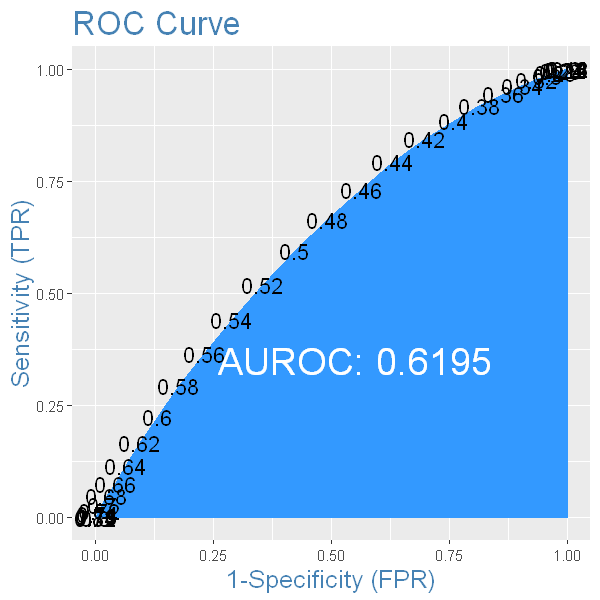

In [64]:
options(repr.plot.width=5, repr.plot.height=5)
InformationValue::plotROC(calib$CHURN, predicted,Show.labels = T)

In [65]:
 ks_stat(calib$CHURN, predicted, returnKSTable = T)

rank,total_pop,non_responders,responders,expected_responders_by_random,perc_responders,perc_non_responders,cum_perc_responders,cum_perc_non_responders,difference
1,4000,1422,2578,2000,0.12890,0.07110,0.12890,0.07110,0.0578
2,4000,1539,2461,2000,0.12305,0.07695,0.25195,0.14805,0.1039
3,4000,1675,2325,2000,0.11625,0.08375,0.36820,0.23180,0.1364
4,4000,1781,2219,2000,0.11095,0.08905,0.47915,0.32085,0.1583
5,4000,1856,2144,2000,0.10720,0.09280,0.58635,0.41365,0.1727
6,4000,2002,1998,2000,0.09990,0.10010,0.68625,0.51375,0.1725
7,4000,2083,1917,2000,0.09585,0.10415,0.78210,0.61790,0.1642
8,4000,2290,1710,2000,0.08550,0.11450,0.86760,0.73240,0.1352
9,4000,2530,1470,2000,0.07350,0.12650,0.94110,0.85890,0.0822
10,4000,2822,1178,2000,0.05890,0.14110,1.00000,1.00000,0.0000


Now, we will conduct a decile analysis to see if the model is valid

decile,Min_prob,Max_prob,churn_Count,Non_churn_Count
10,0.6339875,0.8415453,2578,1422
9,0.5919703,0.6339733,2461,1539
8,0.5593636,0.5919694,2325,1675
7,0.5301308,0.5593542,2219,1781
6,0.5022778,0.5301287,2144,1856
5,0.4735879,0.5022756,1998,2002
4,0.4433115,0.4735843,1917,2083
3,0.4086781,0.4433086,1710,2290
2,0.3625175,0.4086696,1470,2530
1,0.1383115,0.3624870,1178,2822


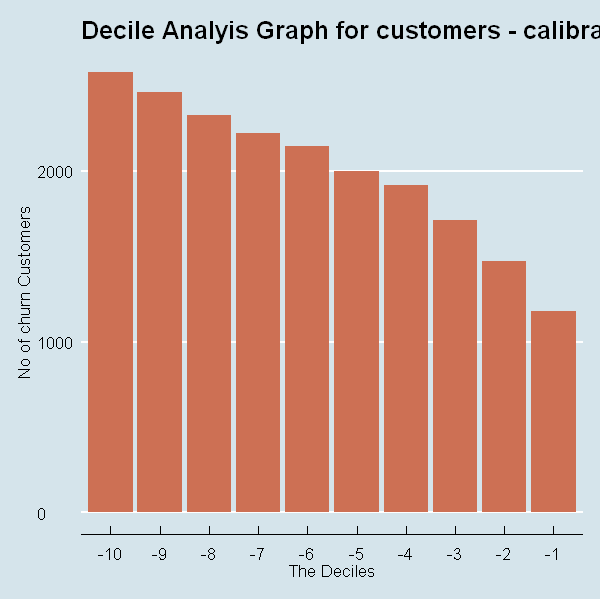

In [72]:
calib <- cbind(calib,pred = predicted)

decLocations <- quantile(calib$pred, probs = seq(0.1,0.9,by=0.1))
calib$decile <- findInterval(calib$pred,c(-Inf,decLocations, Inf))

calib <- data.table(calib)
#calib$CHURN <- as.numeric(calib$CHURN)
fit_train_DA <- calib %>% group_by(decile) %>% dplyr::summarize(Min_prob = min(pred),
                                                                Max_prob = max(pred),
                                                                churn_Count = sum(as.numeric(CHURN)),
                                                                Non_churn_Count = (length(decile)-sum(as.numeric(CHURN)))
) %>% arrange(decile)
fit_train_DA <- dplyr::arrange(fit_train_DA, desc(decile))  
fit_train_DA

DecilePlot <-  ggplot2::ggplot(data = fit_train_DA,aes(x = factor(-decile), y = churn_Count))
DecilePlot <- DecilePlot + geom_bar(stat = 'identity',fill = "salmon3") 
DecilePlot <- DecilePlot + xlab("The Deciles") + ylab("No of churn Customers")
DecilePlot <- DecilePlot + ggtitle("Decile Analyis Graph for customers - calibration data")
DecilePlot <- DecilePlot + theme_economist()
DecilePlot


This forms a smooth step shape, this means that the model is good.

We conduct a similar analysis for the Validity data too

In [86]:
valid<-cbind(valid, pred=predict(fit2, valid, type="response"))
valid$churn_pd <- ifelse(valid$pred>cutoff, 1,0)
paste("This model says that there are", sum(valid$churn_pd) ,"customers who are about to churn.")

[1] "This model says that there are 15160 customers who are about to churn."

In [78]:
InformationValue::confusionMatrix(valid$CHURN, valid$pred, threshold = cutoff)

,0,1
0,15683,204
1,14755,405


In [80]:
paste("Bad Rate:",InformationValue::misClassError(valid$CHURN, valid$pred, threshold = cutoff))

[1] "Bad Rate: 0.4818"

In [81]:
ks_stat(valid$CHURN, valid$pred, returnKSTable = T)

rank,total_pop,non_responders,responders,expected_responders_by_random,perc_responders,perc_non_responders,cum_perc_responders,cum_perc_non_responders,difference
1,3105,3001,104,60.90588,0.17077176,0.09859386,0.1707718,0.09859386,0.07217789
2,3105,3015,90,60.90588,0.14778325,0.09905381,0.3185550,0.19764768,0.12090733
3,3105,3022,83,60.90588,0.13628900,0.09928379,0.4548440,0.29693147,0.15791254
4,3105,3036,69,60.90588,0.11330049,0.09974374,0.5681445,0.39667521,0.17146929
5,3105,3042,63,60.90588,0.10344828,0.09994086,0.6715928,0.49661607,0.17497670
6,3105,3047,58,60.90588,0.09523810,0.10010513,0.7668309,0.59672120,0.17010967
7,3105,3060,45,60.90588,0.07389163,0.10053223,0.8407225,0.69725343,0.14346906
8,3105,3065,40,60.90588,0.06568144,0.10069650,0.9064039,0.79794993,0.10845401
9,3105,3069,36,60.90588,0.05911330,0.10082791,0.9655172,0.89877784,0.06673940
10,3102,3081,21,60.84704,0.03448276,0.10122216,1.0000000,1.00000000,0.00000000


Decile Analysis

decile,Min_prob,Max_prob,churn_Count,Non_churn_Count
10,0.6160525,0.8438721,104,3001
9,0.5702602,0.6160420,90,3015
8,0.5359044,0.5702532,83,3021
7,0.5059479,0.5358990,69,3036
6,0.4786657,0.5059432,63,3042
5,0.4506350,0.4786504,58,3046
4,0.4218971,0.4506291,45,3060
3,0.3890757,0.4218730,40,3064
2,0.3445732,0.3890652,36,3069
1,0.1529250,0.3445549,21,3084


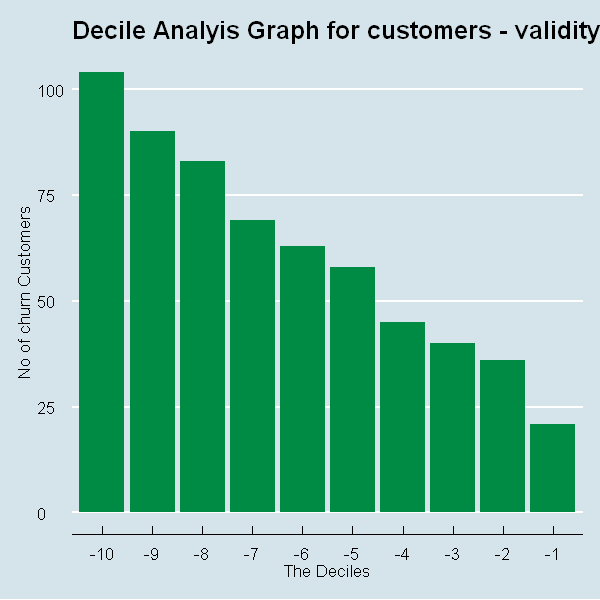

In [87]:
decLocations <- quantile(valid$pred, probs = seq(0.1,0.9,by=0.1))
valid$decile <- findInterval(valid$pred,c(-Inf,decLocations, Inf))

valid <- data.table(valid)
fit_test_DA <- valid %>% group_by(decile) %>% dplyr::summarize(Min_prob = min(pred),
                                                               Max_prob = max(pred),
                                                               churn_Count = sum(as.numeric(CHURN)),
                                                               Non_churn_Count = (length(decile)-sum(as.numeric(CHURN)))
) %>% arrange(decile)
fit_test_DA <- dplyr::arrange(fit_test_DA, desc(decile))  
fit_test_DA

DecilePlot <-  ggplot2::ggplot(data = fit_test_DA,aes(x = factor(-decile), y = churn_Count))
DecilePlot <- DecilePlot + geom_bar(stat = 'identity',fill = "springgreen4") 
DecilePlot <- DecilePlot + xlab("The Deciles") + ylab("No of churn Customers")
DecilePlot <- DecilePlot + ggtitle("Decile Analyis Graph for customers - validity data")
DecilePlot <- DecilePlot + theme_economist()
DecilePlot

Though, this logistic regression model gives a good model, unfortunately the model does not have good predictive accuracy.